In [1]:
import math
import numpy as np
import matplotlib
import os
import sys
import math
from statistics import mean
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import Robothym 

In [13]:
thym=Robothym.Robothym()
thym.setCurrPos((0,0,0))
glob=[(1,2),(3,4),(7,8),(6,6)]
thym.set_globalpath(glob)
x=[]
x.append(thym.getCurrPos())
i=0
node_index=0
Ts=0.001
thym.set_steptime(0.001)
next=glob[0]
thym.set_goal(next)

while i<30000:
    if thym.rho:
        if node_index < len(glob) and thym.rho < thym.on_node :  
            node_index+=1
            next=glob[node_index]
            thym.set_goal(next)

    thym.ikine()
    thym.fkine()
    temp=thym.getCurrPos()
    x.append(temp)
    i+=1

x=np.array(x)
path=np.array(glob)

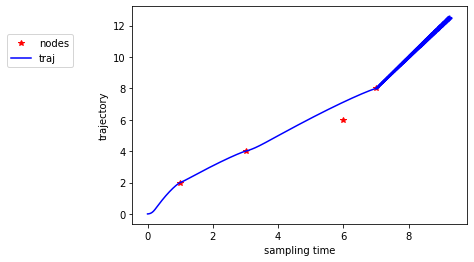

In [14]:
        figg1, (ax1) = plt.subplots()
        ax1.plot(path[:,0],path[:,1],'r*',label="nodes")
        ax1.plot(x[:,0],x[:,1],'b',label="traj")
        ax1.set_xlabel('sampling time')
        ax1.set_ylabel('trajectory')
        figg1.legend(bbox_to_anchor=(0, 0.8))
        plt.show()

In [ ]:
print(x)